In [2]:
import pandas as pd
import numpy as np
import torch
import torch_geometric
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt


# GCN class definition
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Load and preprocess data
data = pd.read_csv('C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/7Oct_270Dataset/5VI_CD_CV_16ENV_270_01.csv')
X = data.drop('Seed', axis=1)  # Features
#X = data[['Cire_CD', 'NDRE_CD']]
y = data['Seed']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the entire dataset
X_scaled = scaler.fit_transform(X)

# Create a similarity graph using cosine similarity
similarity = cosine_similarity(X_scaled)
edges = np.transpose(np.nonzero(similarity > 0.5))  # Adjust threshold as needed

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y.values, dtype=torch.float).unsqueeze(1)  # Ensure y is the correct shape

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Split indices for training and testing
train_indices, test_indices = train_test_split(np.arange(data.y.size(0)), test_size=0.2, random_state=42)

# Create datasets for given indices
train_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in train_indices]
test_dataset = [Data(x=data.x, edge_index=data.edge_index, y=data.y[i]) for i in test_indices]

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the number of features
num_node_features = x.size(1)

# Choose the model to train
model = GCN(num_node_features, 1)  # Assuming regression, set the number of output features to 1

# Initialize the loss function and optimizer
criterion = torch.nn.MSELoss()  # Use Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):  # number of epochs
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        print("Output shape:", out.shape, "Target shape:", batch.y.shape)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation loop
predicted = []
actual = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        # Reshape the output to match the actual labels
        batch_predictions = out.detach().numpy().flatten()
        batch_actual = batch.y.numpy().flatten()
        # Truncate the predictions to match the length of batch_actual
        batch_predictions = batch_predictions[:len(batch_actual)]
        predicted.extend(batch_predictions)
        actual.extend(batch_actual)

# Convert lists to NumPy arrays
predicted = np.array(predicted)
actual = np.array(actual)


#Check Shapes Consistency
print("Predicted shape:", predicted.shape)
print("Actual shape:", actual.shape)


# Calculate MAE, MSE, RMSE, and R2
gnn_mae = mean_absolute_error(actual, predicted)
gnn_mse = mean_squared_error(actual, predicted)
gnn_rmse = np.sqrt(gnn_mse)
gnn_r2 = r2_score(actual, predicted)

# Evaluate GNN model on test set and store metrics
gnn_results = {
    "Method": "GNN",
    "MAE": gnn_mae,
    "MSE": gnn_mse,
    "RMSE": gnn_rmse,
    "R2": gnn_r2
}

#######################################

# Ensemble methods setup and training (from GNN1.txt)
#######################################
# Best hyperparameters obtained from previous runs
best_params = {
    "Huber": {'alpha': 1, 'epsilon': 1.0, 'max_iter': 100},
    "M-estimators": {'min_samples': 0.6, 'stop_probability': 0.97},
    "Linear Regression": {'fit_intercept': True},
    "Ridge Regression": {'alpha': 0.615848211066026, 'fit_intercept': True, 'solver': 'sparse_cg'}
}

# Initialize models with default parameters
default_models = {
    "Huber": HuberRegressor(),
    "M-estimators": RANSACRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge()
}

###########################################

# Initialize models with best parameters
tuned_models = {
    "Huber": HuberRegressor(**best_params["Huber"]),
    "M-estimators": RANSACRegressor(**best_params["M-estimators"]),
    "Linear Regression": LinearRegression(**best_params["Linear Regression"]),
    "Ridge Regression": Ridge(**best_params["Ridge Regression"])
}

# Define ensemble methods with weights
ensemble_methods = {

   "PEnsemble1": {"models": ["Huber", "M-estimators", "Linear Regression", "Ridge Regression"], "weights": [0.5, 0.3, 0.1, 0.1]},  #0.924202
   "PEnsemble2": {"models": ["Huber", "M-estimators", "Linear Regression"], "weights": [0.45, 0.35, 0.2]}, #0.924131
   "PEnsemble3": {"models": ["Huber", "M-estimators", "Ridge Regression"], "weights": [0.45, 0.35, 0.2]}, #0.924017
    "PEnsemble4": {"models": ["Huber", "M-estimators"], "weights": [0.6, 0.4]} #0.925427

}

# Evaluate Ensemble models on test set and store metrics
ensemble_results = []
for method, details in ensemble_methods.items():
    ensemble_predictions = np.zeros(len(y_test))  # Initialize to the same length as y_test
    total_weight = 0

    # Training and predicting with each model in the ensemble
    for model_name, weight in zip(details["models"], details["weights"]):
        model = tuned_models[model_name]
        model.fit(X_train_scaled, y_train)  # Train the model on scaled training data
        predictions = model.predict(X_test_scaled)  # Generate predictions on scaled test data
        ensemble_predictions += weight * predictions  # Weighted sum
        total_weight += weight

    ensemble_predictions /= total_weight  # Normalize by total weight

    # Computing evaluation metrics
    mae = mean_absolute_error(y_test, ensemble_predictions)
    mse = mean_squared_error(y_test, ensemble_predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, ensemble_predictions)

    # Appending results
    ensemble_results.append({
        "Method": method,
        "Model": ", ".join(details["models"]),
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

# Combine GNN and ensemble results
all_results = pd.DataFrame([gnn_results] + ensemble_results)
print(all_results)




Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([8640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([6480, 1]) Target shape: torch.Size([24])
Epoch 1, Loss: 41.19269561767578
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([6480, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([6480, 1]) Target shape: torch.Size([24])
Epoch 2, Loss: 26.59214973449707
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([6480, 1]) Target shape: torch.Size([24])
Epoch 3, Loss: 14.625961303710938
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([32])
Output shape: torch.Size([8640, 1]) Target shape: torch.Size([

c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

       Method       MAE       MSE      RMSE        R2  \
0         GNN  2.173708  7.721979  2.778845 -0.049518   
1  PEnsemble1  0.345189  0.648509  0.805301  0.911859   
2  PEnsemble2  0.360108  0.666893  0.816635  0.909360   
3  PEnsemble3  0.347641  0.649941  0.806189  0.911664   
4  PEnsemble4  0.330878  0.634385  0.796483  0.913779   

                                               Model  
0                                                NaN  
1  Huber, M-estimators, Linear Regression, Ridge ...  
2             Huber, M-estimators, Linear Regression  
3              Huber, M-estimators, Ridge Regression  
4                                Huber, M-estimators  


c:\Users\Nisit\anaconda3\envs\qgisconda\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


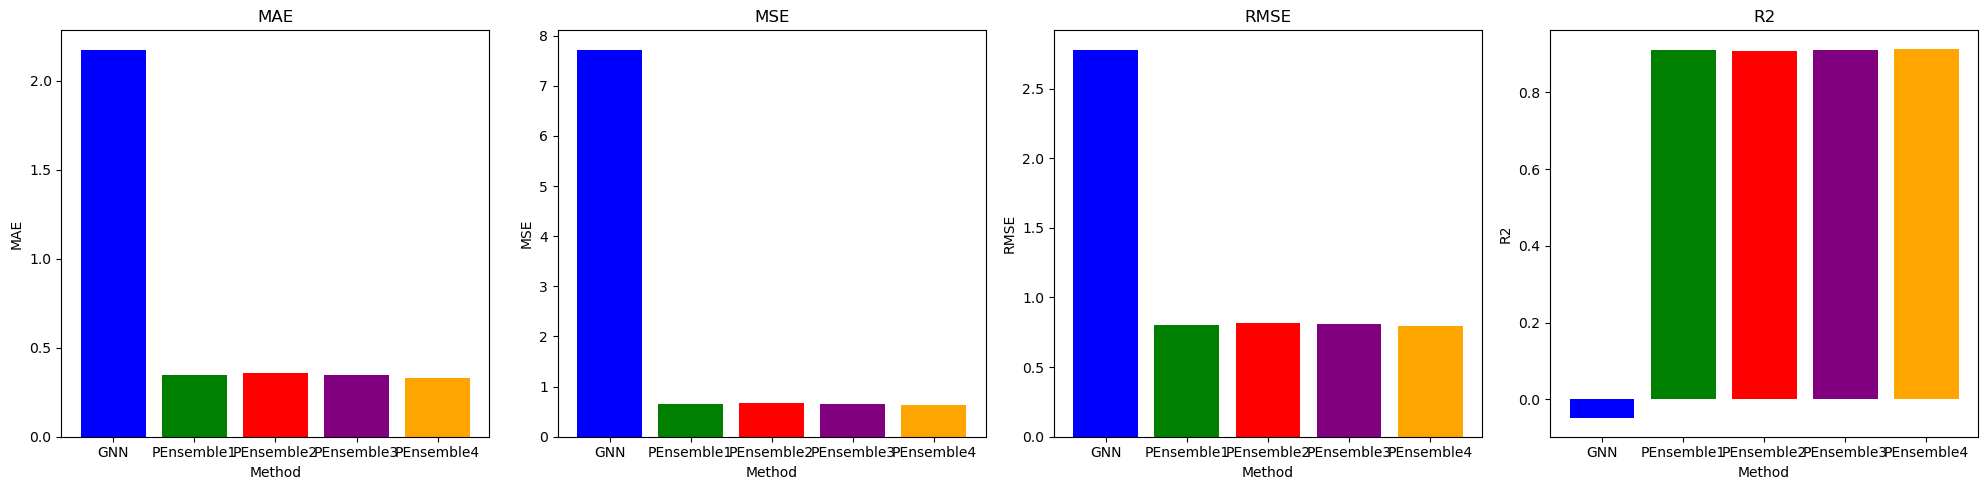

In [3]:
import matplotlib.pyplot as plt

# Combine GNN and ensemble results
all_results = pd.DataFrame([gnn_results] + ensemble_results)

# Plot settings
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
n_metrics = len(metrics)
colors = ['blue', 'green', 'red', 'purple', 'orange']
methods = all_results['Method']

# Create subplots
fig, axs = plt.subplots(1, n_metrics, figsize=(n_metrics * 5, 5))

for i, metric in enumerate(metrics):
    axs[i].bar(methods, all_results[metric], color=colors[:len(methods)])
    axs[i].set_title(metric)
    axs[i].set_xlabel('Method')
    axs[i].set_ylabel(metric)

# Display the plot
plt.tight_layout()
plt.show()


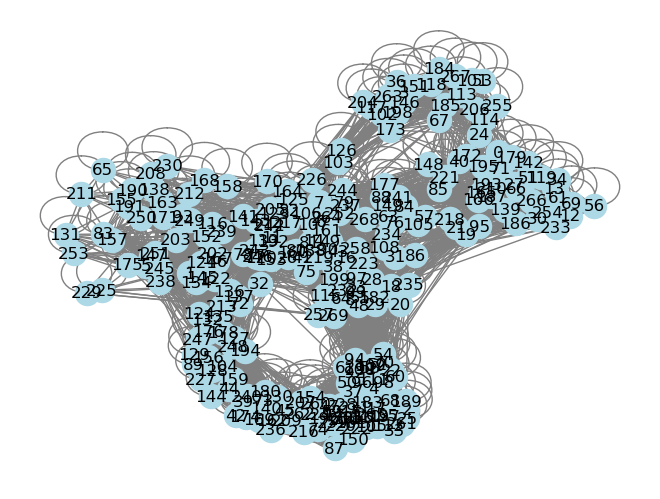

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'edge_index' is a tensor of shape [2, num_edges] representing your graph edges
G = nx.Graph()
for i in range(edge_index.shape[1]):
    source = edge_index[0, i].item()
    target = edge_index[1, i].item()
    G.add_edge(source, target)

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()


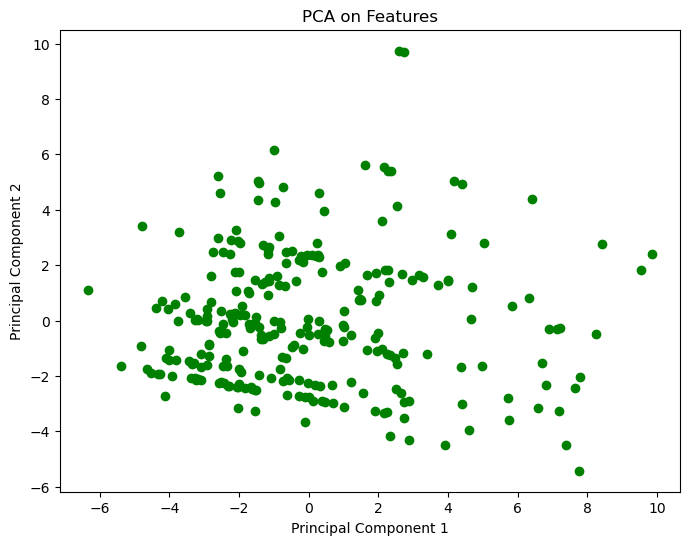

In [5]:
from sklearn.decomposition import PCA

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Features')
plt.show()

In [26]:
import matplotlib.pyplot as plt

# Metrics from the user's script
results = {
    "GNN": {"MAE": 2.178221, "MSE": 7.742598, "RMSE": 2.782552, "R2": -0.052320},
    "PEnsemble1": {"MAE": 0.345189, "MSE": 0.648509, "RMSE": 0.805301, "R2": 0.911859},
    "PEnsemble2": {"MAE": 0.354429, "MSE": 0.652517, "RMSE": 0.807785, "R2": 0.911314},
    "PEnsemble3": {"MAE": 0.347641, "MSE": 0.649941, "RMSE": 0.806189, "R2": 0.911664},
    "PEnsemble4": {"MAE": 0.331403, "MSE": 0.640786, "RMSE": 0.800491, "R2": 0.912909}
}

# Extracting the values for plotting
methods = list(results.keys())
mae_values = [results[method]['MAE'] for method in methods]
mse_values = [results[method]['MSE'] for method in methods]
rmse_values = [results[method]['RMSE'] for method in methods]
r2_values = [results[method]['R2'] for method in methods]

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotting MAE
axs[0, 0].bar(methods, mae_values, color='skyblue')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('MAE')

# Plotting MSE
axs[0, 1].bar(methods, mse_values, color='lightgreen')
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_ylabel('MSE')

# Plotting RMSE
axs[1, 0].bar(methods, rmse_values, color='salmon')
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')
axs[1, 0].set_ylabel('RMSE')

# Plotting R2
axs[1, 1].bar(methods, r2_values, color='orchid')
axs[1, 1].set_title('R2 Score')
axs[1, 1].set_ylabel('R2')

# Adjusting layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/5April24/model_comparisons.png')
plt.close()

'C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/5April24/model_comparisons.png'


'C:/Maize_Chainat_C/45Datapoint_Master/ML_analysis/5April24/model_comparisons.png'